<a href="https://colab.research.google.com/github/7sr7/Intro-to-AI-HW2/blob/main/Silvestre_Intro_to_AI_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: KNN

# HW2: K-Nearest Neighbors Classification (25 points)

This notebook will guide you through:

- Preparing and exploring the MNIST dataset
- Computing simple features
- Implementing a KNN classifier from scratch
- Evaluating and analyzing your results


In [276]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import center_of_mass
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import sys
import warnings
# Ignore all user warnings (including NumPy/SciPy compatibility)
warnings.filterwarnings("ignore", category=UserWarning)
# Load Data
try:
  data = np.load("mnist_10k_trainval.npz")
except:
  # i am using google colab to complete this assignment

  # mounting to google drive...
  from google.colab import drive
  drive.mount('/content/drive')

  data = np.load("/content/drive/MyDrive/mnist_10k_trainval.npz")

x_all = data["x"]
y_all = data["y"]

print("Images shape:", x_all.shape)
print("Labels shape:", y_all.shape)
print("Label classes:", np.unique(y_all))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images shape: (10000, 28, 28)
Labels shape: (10000,)
Label classes: [0 1 2 3 4 5 6 7 8 9]


---
## Preprocessing the Data
Conduct any data manipulation you require to obtain the features dataframe (df_features in HW2_Starter).
You must showcase at least 3 features for each image. You can add additional features if you wish.



In [277]:
# TODO: Preprocess the data and create your features DataFrame
# You must compute at least 3 features per image and combine them with the labels.


# preprocessing -- flattening image data and normalizing pixels...
# Flatten: (28,28) -> (784,)
x_all_flat = x_all.reshape(len(x_all), -1)


# Normalize to [0,1]
x_all_norm = x_all_flat / 255.0


# feature extraction...
# Count of pixels > 0.5
threshold_counts = (x_all_flat > 0.5).sum(axis=1)


# Mean pixel intensity per image
mean_intensity = x_all_flat.mean(axis=1)


# Standard deviation of pixel intensity per image
std_intensity = x_all_flat.std(axis=1)


# count of how many nonzero pixels there are
nonzero_counts = (x_all_flat > 0).sum(axis=1)


# for extracting various features regarding shape of the number...
# these include:
# - number of pixels in each quadrant
# - center of mass
# - vertical and horizontal symmetry
#
# originally, i passed this dataframe containing all these values to my KNN classifier
# but i observed that the accuracy was not too great
# i observed it was more favorable to just calculate distance from the flattened image
# data alone...
def extractShapeFeatures(imgs):
  features = []

  for img in imgs:
    # quadrants...
    q1 = img[:14, :14].sum()
    q2 = img[:14, 14:].sum()
    q3 = img[14:, :14].sum()
    q4 = img[14:, 14:].sum()


    # center of mass...
    # gets (row, col) = (y, x)
    comY, comX = center_of_mass(img)


    # symmetry...
    # horizontal symmetry...
    top = img[:14, :].astype(np.int16)
    bottom = np.flipud(img[14:, :]).astype(np.int16)
    horizontalSymmetry = -np.abs(top - bottom).sum()

    # vertical symmetry...
    left = img[:, :14].astype(np.int16)
    right = np.fliplr(img[:, 14:]).astype(np.int16)
    verticalSymmetry = -np.abs(left - right).sum()

    features.append([q1, q2, q3, q4, comY, comX, horizontalSymmetry, verticalSymmetry])

  return np.array(features)



shapeFeatures = extractShapeFeatures(x_all)


allQuads = shapeFeatures[:, :4]
allCOM = shapeFeatures[:, 4:6]
allSymmetry = shapeFeatures[:, 6:8]


# creating features DataFrame...
df_features = pd.DataFrame({
  "mean_intensity": mean_intensity,
  "std_intensity": std_intensity,
  "threshold_count": threshold_counts,
  "nonzero_count": nonzero_counts,
  "q1": allQuads[:, 0],
  "q2": allQuads[:, 1],
  "q3": allQuads[:, 2],
  "q4": allQuads[:, 3],
  "com_y": allCOM[:, 0],
  "com_x": allCOM[:, 1],
  "symmetry_h": allSymmetry[:, 0],
  "symmetry_v": allSymmetry[:, 1],
})


print(df_features.head(5))
print(df_features.shape)


   mean_intensity  std_intensity  threshold_count  nonzero_count      q1  \
0       58.743622      98.097954              250            250  9445.0   
1       35.834184      81.001641              157            157  6810.0   
2       34.992347      78.202200              171            171  8699.0   
3       25.327806      70.768745              111            111  4011.0   
4       31.229592      77.376487              134            134  4998.0   

        q2       q3       q4      com_y      com_x  symmetry_h  symmetry_v  
0  13827.0  12265.0  10518.0  13.813918  14.103224    -19285.0    -17943.0  
1   6598.0   3848.0  10838.0  13.886488  14.304335    -15336.0    -10632.0  
2   4784.0   4526.0   9425.0  14.289896  13.928410    -19112.0    -18454.0  
3   5550.0   4215.0   6081.0  14.371960  14.048849    -10017.0    -12081.0  
4   9298.0   5386.0   4802.0  13.594429  14.235174    -14744.0    -13362.0  
(10000, 12)


In [278]:
# normalizing the features... (for both training and validation)
scaler = MinMaxScaler()
normalized = scaler.fit_transform(df_features)

df_featuresNorm = pd.DataFrame(normalized, columns=df_features.columns)

print(df_featuresNorm.head(5))

   mean_intensity  std_intensity  threshold_count  nonzero_count        q1  \
0        0.543770       0.742228         0.672078       0.672078  0.513427   
1        0.298635       0.532989         0.370130       0.370130  0.370189   
2        0.289627       0.498728         0.415584       0.415584  0.472875   
3        0.186215       0.407751         0.220779       0.220779  0.218037   
4        0.249365       0.488622         0.295455       0.295455  0.271689   

         q2        q3        q4     com_y     com_x  symmetry_h  symmetry_v  
0  0.662403  0.630818  0.445602  0.313912  0.603167    0.487538    0.437395  
1  0.316087  0.197912  0.459159  0.386485  0.804350    0.593602    0.678229  
2  0.229185  0.232783  0.399297  0.789914  0.428289    0.492184    0.420562  
3  0.265881  0.216788  0.257626  0.871982  0.548772    0.736463    0.630497  
4  0.445435  0.277015  0.203440  0.094411  0.735164    0.609503    0.588299  


---
**Note:** Decide your own train/validation/testing split here. You must clearly document it.


In [279]:
# TODO: Decide your split strategy here
# Example: use the first 1000 for training, next 1000 for validation
# You must document your choice.


# we have a test set already, so we dont need to use this 10k dataset to split with
# the test set in mind...

# i would like to give "ample" data observation for the purpose of training
# therefore, i am going with a 90 10 split for training and validation...

# training split...
x_train = x_all[:9000]
y_train = y_all[:9000]

df_featuresTrain = df_featuresNorm[:9000]
x_train_flattened_norm = x_all_norm[:9000]

# validation split...
x_val = y_all[9000:]
y_val = y_all[9000:]

df_featuresVal = df_featuresNorm[9000:]
x_val_flattened_norm = x_all_norm[9000:]

# df_featuresTrain.head()

---
## KNN Classifier

Implement your KNN classifier here.


In [280]:
# Example function stub, feel free to edit it in any shape or form outside of the function name
def knn_predictor(x_train, y_train, x_test, k):

  #Implement KNN here
  allPredictions = []

  for i in x_test:
    distances = []

    # computing euclidean distances to all training points...
    distances = np.linalg.norm(i - x_train, axis=1)


    # get the k smallest distances...
    neighInd = np.argsort(distances)[:k]


    # labels of the k smallest distances...
    neighLabels = y_train[neighInd]


    # majority vote...
    allLabels = {}
    maxCandidates = []

    # for breaking ties...
    if False:
      majorityLabel = -1
      majorityCount = -1

      for label in neighLabels:
        if (label in allLabels):
          allLabels[label] += 1
        else:
          allLabels[label] = 1

          if (allLabels[label] > majorityCount):
            majorityCount = allLabels[label]
            majorityLabel = label

      for label, count in allLabels.items():
        if (count == majorityCount):
          maxCandidates.append(label)

      if (len(maxCandidates) > 1):
        majorityLabel = min(maxCandidates)

    else:
      mostCommon = collections.Counter(neighLabels).most_common(1)[0][0]

      majorityLabel = mostCommon

    allPredictions.append(majorityLabel)

  return np.array(allPredictions)


---
## Evaluate Accuracy for Different k Values

In this step, you will:

- Choose a list of values for $k$ (for example: 1, 3, 5, 7, 9). Choose at least 5 values to test k for, you can explore further values to explore trends or to determine a best value.
- Use your `knn_predictor` function to make predictions on the validation set for each $k$.
- Calculate the accuracy for each $k$ by comparing predictions to the true labels.
- Print out the results so you can see which $k$ performs best.


**Note:** You can use either odd or even values for $k$. If you encounter ties in majority voting, break them consistently (for example, by choosing the smallest label).


In [281]:
# TODO: Evaluate accuracy for different k values

kVals = [2 * i + 1 for i in range(5)]

accuracies = {} # Store your accuracies in a dictionary so you can easily compare them later.

for k in kVals:
  # running the full training and validation takes up way too much time...
  # this makes sense since we are computing 1000 * 9000, since for each validation
  # point, we are calculating distances of all the training pts...
  # thus, i limited the data to the first 1000 samples...
  # preds = knn_predictor(x_train_norm, y_train, x_val_norm, k)

  preds = knn_predictor(x_train_flattened_norm[:1000], y_train[:1000], x_val_flattened_norm[:1000], k)

  correct = (preds == y_val[:1000])
  accuracy = np.mean(correct)
  accuracies[k] = accuracy

  print(f"k = {k}, accuracy = {accuracy:.4f}")

maxAccuracy = max(accuracies.values())
bestK = max(accuracies, key=accuracies.get)

print(f"\n\nHighest performing k is {bestK} with an accuracy of {maxAccuracy}.")

k = 1, accuracy = 0.8840
k = 3, accuracy = 0.8860
k = 5, accuracy = 0.8880
k = 7, accuracy = 0.8840
k = 9, accuracy = 0.8750


Highest performing k is 5 with an accuracy of 0.888.


## Evaluating on the Test Set

In this step, you will use your KNN classifier with the best $k$ value to predict labels for the test set and evaluate its performance.

Since the test set includes labels, you can:

- Calculate the accuracy on the test set


In [282]:
#Testing the KNN Model

In [283]:
# TODO: Evaluate your KNN classifier on the test set

# Load test data
try:
  test_data = np.load("mnist_1k_test.npz")

except:
  test_data = np.load("/content/drive/MyDrive/mnist_1k_test.npz")

x_test = test_data["x"]
y_test = test_data["y"]

# Do any preprocessing required
# Flatten: (28,28) -> (784,)
x_test_flat = x_test.reshape(len(x_test), -1)

# Normalize to [0,1]
x_test_flattened_norm = x_test_flat / 255.0

# feature extraction...
# Count of pixels > 0.5
threshold_countsTest = (x_test_flat > 0.5).sum(axis=1)


# Mean pixel intensity per image
mean_intensityTest = x_test_flat.mean(axis=1)


# Standard deviation of pixel intensity per image
std_intensityTest = x_test_flat.std(axis=1)


# count of how many nonzero pixels there are
nonzero_countsTest = (x_test_flat > 0).sum(axis=1)

# making dataframe...
shapeFeaturesTest = extractShapeFeatures(x_test)

allQuadsTest = shapeFeaturesTest[:, :4]
allCOMTest = shapeFeaturesTest[:, 4:6]
allSymmetryTest = shapeFeaturesTest[:, 6:8]

# creating features DataFrame...
df_featuresTest = pd.DataFrame({
  "mean_intensity": mean_intensityTest,
  "std_intensity": std_intensityTest,
  "threshold_count": threshold_countsTest,
  "nonzero_count": nonzero_countsTest,
  "q1": allQuadsTest[:, 0],
  "q2": allQuadsTest[:, 1],
  "q3": allQuadsTest[:, 2],
  "q4": allQuadsTest[:, 3],
  "com_y": allCOMTest[:, 0],
  "com_x": allCOMTest[:, 1],
  "symmetry_h": allSymmetryTest[:, 0],
  "symmetry_v": allSymmetryTest[:, 1],
})


# Predict using your best k from the validation set.
preds = knn_predictor(x_train_flattened_norm[:1000], y_train[:1000], x_test_flattened_norm[:1000], bestK)

# Calculate accuracy by comparing your predicted labels vs the actual ones in y_test
test_correct = (preds == y_test)
test_accuracy = np.mean(test_correct)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.8780


As per the HW instructions, below is the KNN algorithm when run on my DataFrame... (For my analysis, I am using my original knn prediction algorithm, not on the dataframe...)

In [284]:
# Example function stub, feel free to edit it in any shape or form outside of the function name
def knn_predictorDF(x_train, y_train, x_test, k):
  x_train = x_train.to_numpy()
  x_test = x_test.to_numpy()


  #Implement KNN here
  allPredictions = []

  for i in x_test:
    distances = []

    # computing euclidean distances to all training points...
    distances = np.linalg.norm(i - x_train, axis=1)


    # get the k smallest distances...
    neighInd = np.argsort(distances)[:k]


    # labels of the k smallest distances...
    neighLabels = y_train[neighInd]


    # majority vote...
    allLabels = {}
    maxCandidates = []

    # for breaking ties...
    if False:
      majorityLabel = -1
      majorityCount = -1

      for label in neighLabels:
        if (label in allLabels):
          allLabels[label] += 1
        else:
          allLabels[label] = 1

          if (allLabels[label] > majorityCount):
            majorityCount = allLabels[label]
            majorityLabel = label

      for label, count in allLabels.items():
        if (count == majorityCount):
          maxCandidates.append(label)

      if (len(maxCandidates) > 1):
        majorityLabel = min(maxCandidates)

    else:
      mostCommon = collections.Counter(neighLabels).most_common(1)[0][0]

      majorityLabel = mostCommon

    allPredictions.append(majorityLabel)

  return np.array(allPredictions)


In [285]:
# TODO: Evaluate accuracy for different k values

kVals = [2 * i + 1 for i in range(5)]

accuraciesDF = {} # Store your accuracies in a dictionary so you can easily compare them later.

for k in kVals:
  # running the full training and validation takes up way too much time...
  # this makes sense since we are computing 1000 * 9000, since for each validation
  # point, we are calculating distances of all the training pts...
  # thus, i limited the data to the first 1000 samples...
  # preds = knn_predictor(x_train_norm, y_train, x_val_norm, k)

  predsDF = knn_predictorDF(df_featuresTrain[:1000], y_train[:1000], df_featuresVal[:1000], k)

  correctDF = (predsDF == y_val[:1000])
  accuracyDF = np.mean(correctDF)
  accuraciesDF[k] = accuracyDF

  print(f"k = {k}, accuracy = {accuracyDF:.4f}")

maxAccuracyDF = max(accuraciesDF.values())
bestKDF = max(accuraciesDF, key=accuraciesDF.get)

print(f"\n\nHighest performing k is {bestKDF} with an accuracy of {maxAccuracyDF}.")

k = 1, accuracy = 0.3230
k = 3, accuracy = 0.3420
k = 5, accuracy = 0.3460
k = 7, accuracy = 0.3500
k = 9, accuracy = 0.3570


Highest performing k is 9 with an accuracy of 0.357.


In [286]:
# Predict using your best k from the validation set.
predsTest = knn_predictorDF(df_featuresTrain[:1000], y_train[:1000], df_featuresTest[:1000], bestK)

# Calculate accuracy by comparing your predicted labels vs the actual ones in y_test
test_correctDF = (predsTest == y_test)
test_accuracyDF = np.mean(test_correctDF)
print(f"Test set accuracy: {test_accuracyDF:.4f}")

Test set accuracy: 0.0940


## Reflection and Analysis

Answer the following questions. You may include text, plots, and code as needed.

---

### 1. Effect of k on Validation Accuracy

- How did changing \(k\) affect your validation accuracy?
- Create a plot showing accuracy for each \(k\).

*Add your plot and brief explanation below:*


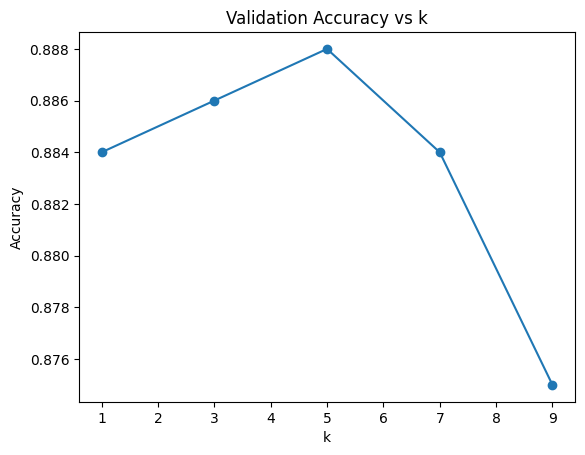

In [287]:
# Example: plotting accuracy vs k
import matplotlib.pyplot as plt


plt.plot(kVals, accuracies.values(), marker = 'o')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs k")
plt.show()


- Why do you think this the plot looks like it does and how does changing $k$ affect your accuracy on the validation set?




*Write your answer here.*

main idea:
overfitting as we have low k because we take in the noise

underfitting as we have high k because the neighborhood becomes too blurry

so the most optimal is in btwn

## 2. Confusion Matrix Analysis

#### What is a Confusion Matrix?

A **confusion matrix** is a table used to evaluate the performance of a classification model.

- Each **row** represents the actual class.
- Each **column** represents the predicted class.
- The diagonal cells show the number of correct predictions for each class.
- The off-diagonal cells show where the model made mistakes (e.g., predicting a 5 when the true label was 3).

This visualization helps you see **which digits are most often confused** and where your classifier might need improvement.


- Which digit classes were most frequently confused for your KNN classifier?
- Create and display your confusion matrix to help you observe these patterns in both your validation set and test set.

*Insert your confusion matrix visualization either after the one provided for you or edit the existing code.*


*Write your answer here*

from the confusion matrix shown below, we observe that:


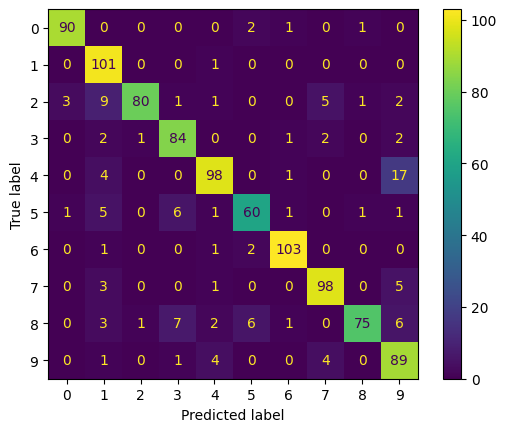

In [288]:
# Example: confusion matrix demonstration with dummy data

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dummy true labels and predictions
# y_ground_truth = np.array([0, 1, 2, 2, 1, 0])
y_ground_truth = y_test
# y_predictions = np.array([0, 2, 2, 2, 1, 0])
y_predictions = preds

# Compute confusion matrix
cm_example = confusion_matrix(y_ground_truth, y_predictions)

# Plot Confusion Matrix
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm_example)
cm_plot.plot()

----
## 3. Runtime Performance

- How long did it take to run predictions for your validation set?
- What about your performance on the test set?
- What impact does the value of $k$ have on this?
- Does the best value of $k$ for your validation set hold true for the test set? Why or Why not?

*You can measure time using the following example code:*
 start_time = time.time()
 preds = knn_predictor(...)
 end_time = time.time()

---
## Additional Analysis
If you want to conduct any additional exploration, you can report it here.

---
Use additional cells if you need more space or want to add extra visualizations.

---
# Part 2: K-Means Clustering (25 points)

### Cheesecake Consumers Dilemma

In this assignment, you will analyze a dataset of customers visiting a cheesecake shop.

Your goals are to:

- Explore the dataset and determine which features you believe are meaningful for clustering
- Experiment with different values of $k$
- Implement K-Means clustering from scratch
- Interpret your results

**Note:** You may use NumPy, Pandas, and Matplotlib. You may not use scikit-learn's `KMeans` for your own implementation. Any provided code can be modified, it is just there to guide you or offer additional insight to the directions.


### Load and Inspect the Data

Load the dataset and explore its structure.


In [289]:
import pandas as pd

# Load the CSV file

try:
  df = pd.read_csv("CheesecakeConsumers.csv")
except:
  df = pd.read_csv("/content/drive/MyDrive/CheesecakeConsumers.csv")
# Conduct any other exploration to determine how to best create a feature space for clustering
# Such as selecting numeric features and applying any normalization techniques on them if needed
# Example:
# X = df[["Age", "Consumer Score"]].values

Doing EDA...

In [290]:
# viewing the first few rows of the data...
df.head()

,CustomerNo,Gender,Age,Spending Power,Consumer Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [291]:
# determining data size...
df.shape

(200, 5)

In [292]:
# general information about the dataset...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerNo      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Spending Power  200 non-null    int64 
 4   Consumer Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [293]:
# # gender may be an interesting factor to contribute to clustering...
# # however, it is represented as a string and does not "fit" well with the other
# # columns which are numeric.
# #
# # thus, making a new column to map each gender to a number that we can then use...
# df['isMale'] = df['Gender'].map({'Female': 0, 'Male': 1})
# df.head()

In [294]:
# statistics of the dataset (numeric columns)...
df.describe()

,CustomerNo,Age,Spending Power,Consumer Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [295]:
# i chose to drop customer number because this is just an increment and i believe
# it does not tell us anything about how to classify the data in clusters
#
# i also ended up dropping gender because of its low standard deviation...
dfDropped = df.drop(columns = ["CustomerNo", "Gender"])

dfDropped.head()

,Age,Spending Power,Consumer Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [296]:
# this shows me how each column is correlated to the other ones...
# the offdiagonals are low, indicating very low correlation, which is
# good for k means since if the features were highly correlated, it could
# distort the results...
dfNum = dfDropped.select_dtypes(include='number')
dfNum.corr()

,Age,Spending Power,Consumer Score
Age,1.000000,-0.012398,-0.327227
Spending Power,-0.012398,1.000000,0.009903
Consumer Score,-0.327227,0.009903,1.000000


In [297]:
# just another way of checking for high correlation...
#
# using VIF to determine highly correlated variables...
# VIF >= 10 indicates high correlation so i want to get rid of variables that are...
#
# source used:https://medium.com/@ajayverma23/understanding-vif-what-it-is-and-why-its-needed-c24125b5c73f
X = dfDropped.select_dtypes(include='number')

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

for i in vif_data.index:
  if vif_data['VIF'][i] >= 10:
    # print(vif_data['feature'][i])
    dfDropped = dfDropped.drop(columns = [vif_data['feature'][i]], axis = 1)

print(vif_data)

if False:
  dfDropped = dfDropped.drop(columns = ["Age"], axis = 1)

print(dfDropped.head())

          feature       VIF
0             Age  4.228978
1  Spending Power  4.872990
2  Consumer Score  3.284642
   Age  Spending Power  Consumer Score
0   19              15              39
1   21              15              81
2   20              16               6
3   23              16              77
4   31              17              40


In [298]:
# normalizing the features...
scaler = MinMaxScaler()
normalized = scaler.fit_transform(dfDropped)

dfFin = pd.DataFrame(normalized, columns=dfDropped.columns)

print(dfFin.head(5))

        Age  Spending Power  Consumer Score
0  0.019231        0.000000        0.387755
1  0.057692        0.000000        0.816327
2  0.038462        0.008197        0.051020
3  0.096154        0.008197        0.775510
4  0.250000        0.016393        0.397959


## K-Means Implementation

Implement K-Means clustering from scratch below.



In [299]:
def kmeans(x_train, k, maxItr, tol): #Remember we don't want an infinite loop so we'll end the algorithm after max_iters
  # initializing centroids...
  allCentroids = []
  allCentroids = x_train[np.random.choice(x_train.shape[0], k, replace=False)]

  # labels = np.zeros(len(x_train))


  for itr in range(maxItr):
    # assigning labels...
    distances = np.linalg.norm(x_train[:, np.newaxis] - allCentroids, axis=2)
    labels = np.argmin(distances, axis=1)


    # updating centroids...
    newCentroids = np.zeros_like(allCentroids)

    for i in range(k):
      newCentroids[i] = np.mean(x_train[labels == i], axis=0)

    # newCentroids = np.array([x_train[labels == i].mean(axis=0) for i in range(k)])


    # checking for convergence...
    if (np.allclose(allCentroids, newCentroids, tol)):
      break

    allCentroids = newCentroids

  return labels, allCentroids

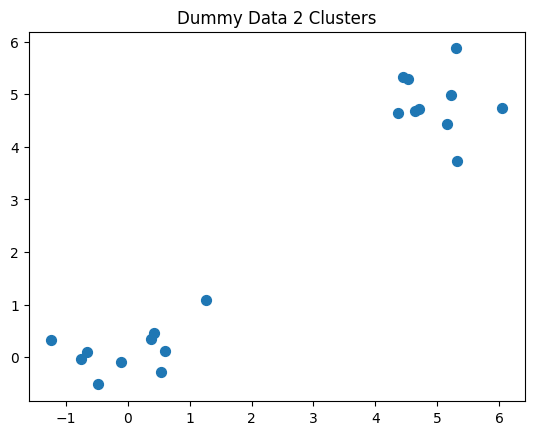

In [323]:

### If you wish to test your implementation prior to interacting with real data
### Feel free to use the following code stub to see if you can cluster the following dummy data

X_test = np.vstack([ np.random.normal(loc=0.0, scale=0.5, size=(10, 2)),
    np.random.normal(loc=5.0, scale=0.5, size=(10, 2))])

plt.scatter(X_test[:,0], X_test[:,1], s=50)
plt.title("Dummy Data 2 Clusters")
plt.show()



Labels shape: (20,)
Labels: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


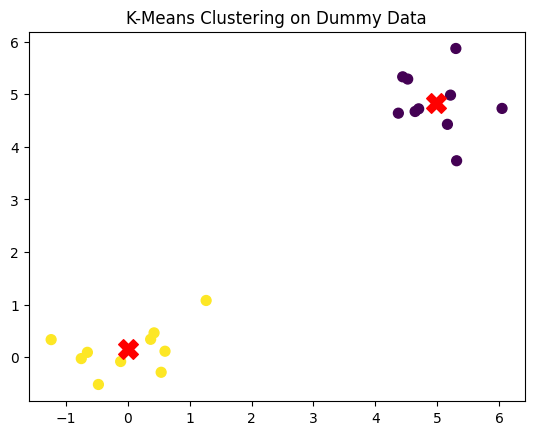

In [324]:
# testing...
labels, centroids = kmeans(X_test, k=2, maxItr=100, tol=1e-4)

print("Labels shape:", labels.shape)
print("Labels:", labels)

# sys.exit(1)

# # Plot points colored by cluster label
plt.scatter(X_test[:, 0], X_test[:, 1], c=labels, cmap='viridis', s=50)

# Plot the centroids as red Xs
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X')

plt.title("K-Means Clustering on Dummy Data")
plt.show()

## Run Your K-Means

Run your implementation with your chosen k on the cheesecake consumer data, feel free to try multiple runs and determine what k best clusters this data.

Defend your best k value after deciding on one, you should use visual aids like scatterplots to make your point.

In [325]:
# Plot your clusters, and centroids. Finalize your best value for k

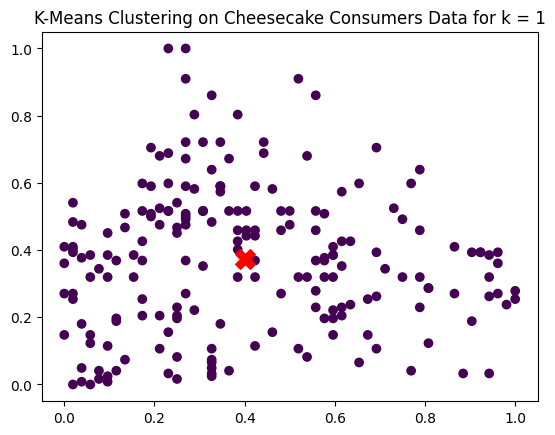

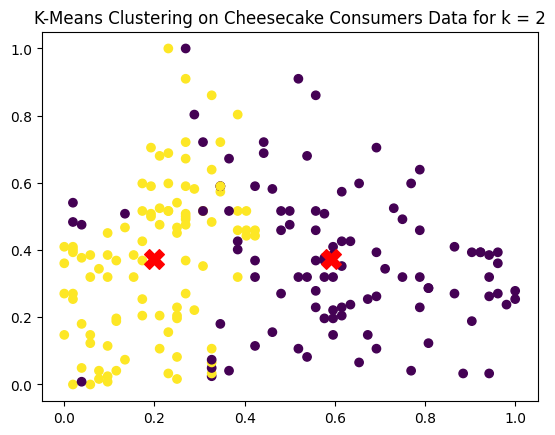

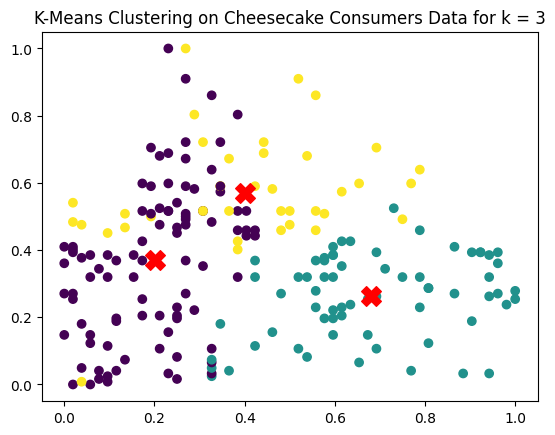

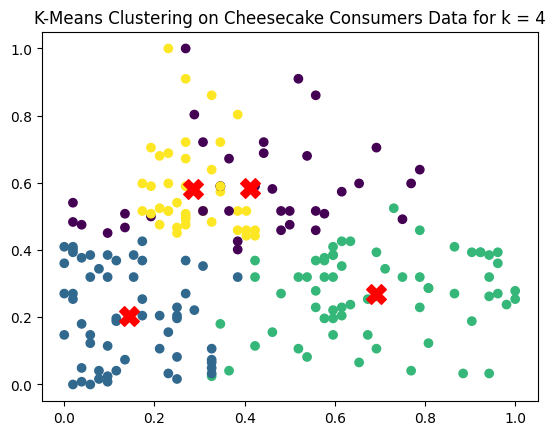

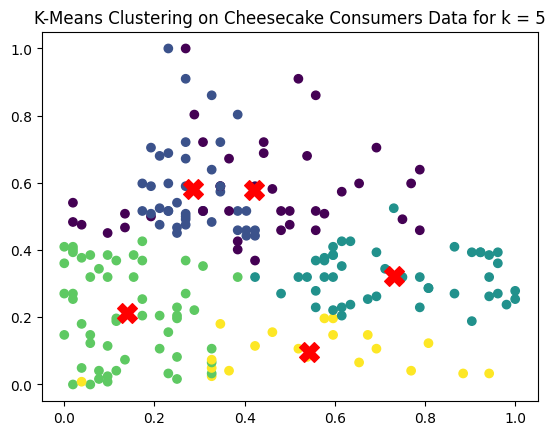

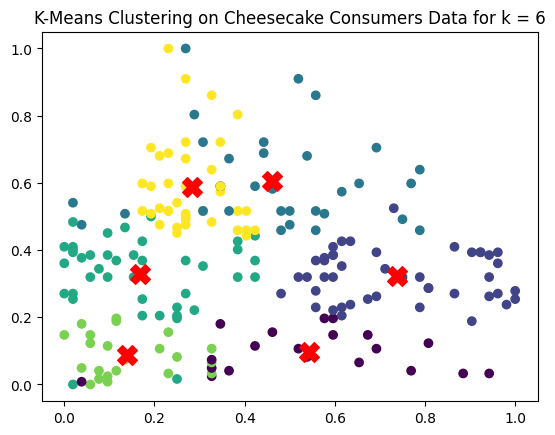

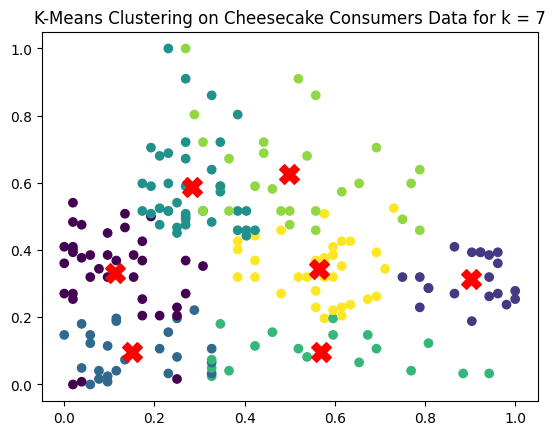

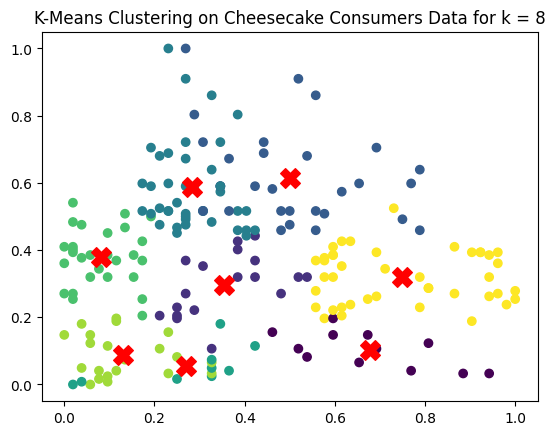

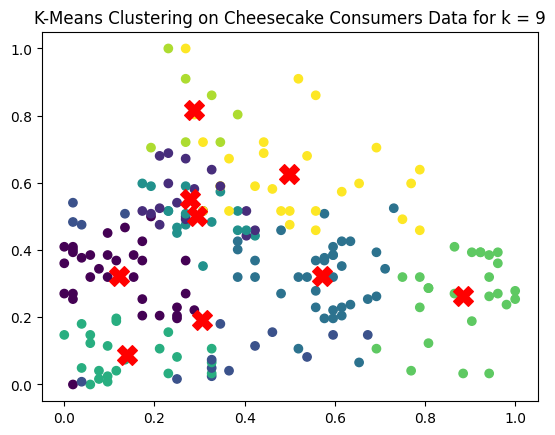

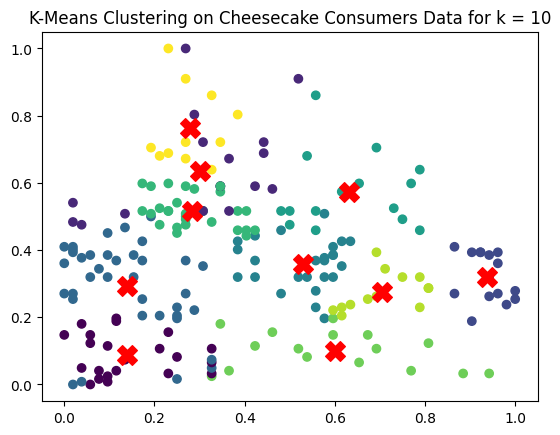

In [331]:
# initialization...
kVals = range(10)
x_train = dfFin.to_numpy()
maxItr = 100
tol = 1e-4
allSSE = []


for k in kVals:
  # running k-means algorithm...
  labels, centroids = kmeans(x_train, k + 1, maxItr, tol)


  # calculating SSE (to be used in determining best k value)...
  distances = np.linalg.norm(x_train[:, np.newaxis] - centroids, axis=2)
  min_dist = np.min(distances, axis=1)
  sse = np.sum(min_dist ** 2)
  allSSE.append(sse)


  # results
  # plotting all the points...
  plt.scatter(x_train[:,0], x_train[:,1], c=labels, cmap="viridis")

  # plotting the centroids...
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids', cmap = "viridis")


  # plt.xlabel("Spending power")
  # plt.ylabel("Age")
  graphTitle = "K-Means Clustering on Cheesecake Consumers Data for k = " + str(k + 1)
  plt.title(graphTitle)
  plt.show()

SSE for k = 1: 22.56077488260975
SSE for k = 2: 17.371946164404164
SSE for k = 3: 14.918693432896985
SSE for k = 4: 10.882035636068334
SSE for k = 5: 9.139245365916791
SSE for k = 6: 7.4634835751996285
SSE for k = 7: 6.995956815786707
SSE for k = 8: 5.784707401297075
SSE for k = 9: 8.055549873487772
SSE for k = 10: 4.818546763656036






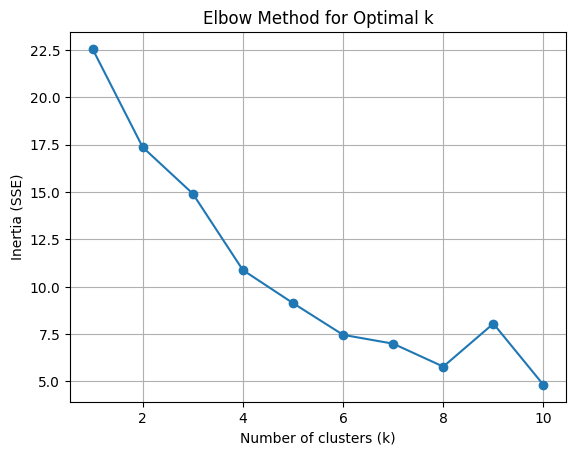

In [327]:
# plotting all SSE...
# the reason we do this is to observe the "elbow", in which our improvement
# flattens out as we increase the number of clusters, k...
#
# from the graph, we observe the "elbow" is at k = 4.
# thus, we conclude k = 4 to be our best k value...

for i in range(len(allSSE)):
  print(f"SSE for k = {i + 1}: {allSSE[i]}")

print("\n\n\n")

plt.plot(kVals, allSSE, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [328]:
# # initialization...
# # kVals = [i for i in range(10)]
# x_train = dfFin.to_numpy()
# maxItr = 100
# tol = 1e-4

# # running k-means...
# for k in range(10):
#   labels, centroids = kmeans(x_train, k + 1, maxItr, tol)


#   # results
#   # plotting all the points...
#   plt.scatter(x_train[:,0], x_train[:,1], c=labels, cmap="viridis")

#   # plotting the centroids...
#   plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids', cmap = "viridis")


#   # plt.xlabel("Spending power")
#   # plt.ylabel("Age")
#   graphTitle = "K-Means Clustering on Cheesecake Consumers Data for k = " + str(k + 1)
#   plt.title(graphTitle)
#   plt.show()


## Testing New Data

Below are 5 new customers alongside their data attributes:

| ID | Age | Gender | Spending Power| Consumer Score (1–100) |
|----|-----|--------|---------------|------------------------|
| 1  | 24  | Female | 25            | 85                     |
| 2  | 52  | Male   | 80            | 20                     |
| 3  | 35  | Female | 55            | 60                     |
| 4  | 42  | Male   | 45            | 30                     |
| 5  | 29  | Female | 90            | 75                     |

**Tasks:**
1. Standardize these 5 samples the same way you processed your original data.
2. Assign each sample to the closest cluster centroid (from your implementation).
3. Plot these points on top of your clustered data, using distinct markers or colors.


*State your reasoning for finalizing on this value of k*

I ran the k means algorithm for k values from 1 to 10. I plotted both the centroids with all data points, as well as the SSE graph.

From here, I determined k = 4 to be the best k value. Particularly observing the SSE graph, we deduce the best k value by observing where the "elbow" in the graph is. That is, the k value at which improvement flattens out. This usually indicates a good balance between underfitting and overfitting the data, which is desirable.

## Analysis and Reflection

Answer the following questions:

1. What patterns or groups do you notice in your clusters?
2. Does the value of max iterations pay a large role in your algorithm? Try various values to showcase your answer.
3. Why might K-Means struggle to perfectly separate customers?
4. If you had more features, what other data would you collect?



*Write answers here*

## Comparison with scikit-learn KMeans

To review your own implementation we will:

- Use scikit-learn's KMeans to cluster the original cheesecake consumers data (Not the testing samples).
- Compare scikit-learn's centroids and labels to your own implementation.
- Reflect on similarities or differences.

**Note:** This is to help you evaluate your implementation, it does not affect your grade if results are not identical.


In [329]:
# TODO: Fit scikit-learn KMeans for comparison

from sklearn.cluster import KMeans

# Fit KMeans
# kmeans_sklearn = KMeans(n_clusters=..., random_state=0)
# kmeans_sklearn.fit(standardized_x)

# Get labels and centroids
# sklearn_labels = kmeans_sklearn.labels_
# sklearn_clusters = kmeans_sklearn.cluster_centers_


In [330]:
# TODO: Plot scikit-learn clusters

import matplotlib.pyplot as plt

# plt.scatter(x_feature_1, x_feature_2, sklearn_labels, cmap='viridis', s=50)
# plt.xlabel("Standardized Feature 1 Name")
# plt.ylabel("Standardized Feature 2 Name")
# plt.title("scikit-learn KMeans Clusters")
# plt.show()


## Reflection on Comparison

Answer the following:

- How similar are the clusters to your implementation?
- Did scikit-learn converge to the same or different centroids?
*Write your reflection below.*
